## ECG Preprocessing

Author: Calvin Chan 

### Introduction
In this notebook, we will focus on cleaning and analyzing our ECG signals. We will look at how the signals are and go over a simple statistical test for the diagnostic classes. Then we will introduce Fourier Analysis and see how it can be used to help with cleaning our signals. Afterwards we will apply that knowledge to perform baseline wandering removal on a sample signal. 

### Table of Contents
- [Reading in signals](#import)
- [Example signal](#example)
- [ANOVA](#statistics)
- [Fourier Analysis](#fourier)

#### Useful links and info
- [ECG cleaning and more](https://neuropsychology.github.io/NeuroKit/functions/ecg.html)
- [Baseline removal](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6209088/pdf/13534_2018_Article_81.pdf)
    

In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wfdb

import sys
sys.path.append('..')
from Models import functions as f

%autosave 300

Autosaving every 300 seconds


<a id='import'></a>
### Reading in signals

We will use the waveform-database package (`wfdb`) to read our files. There are multiple methods to reading in the ECG signals, below we use `rdrecord` and `rdsamp`.

Let's look at one ECG record first:

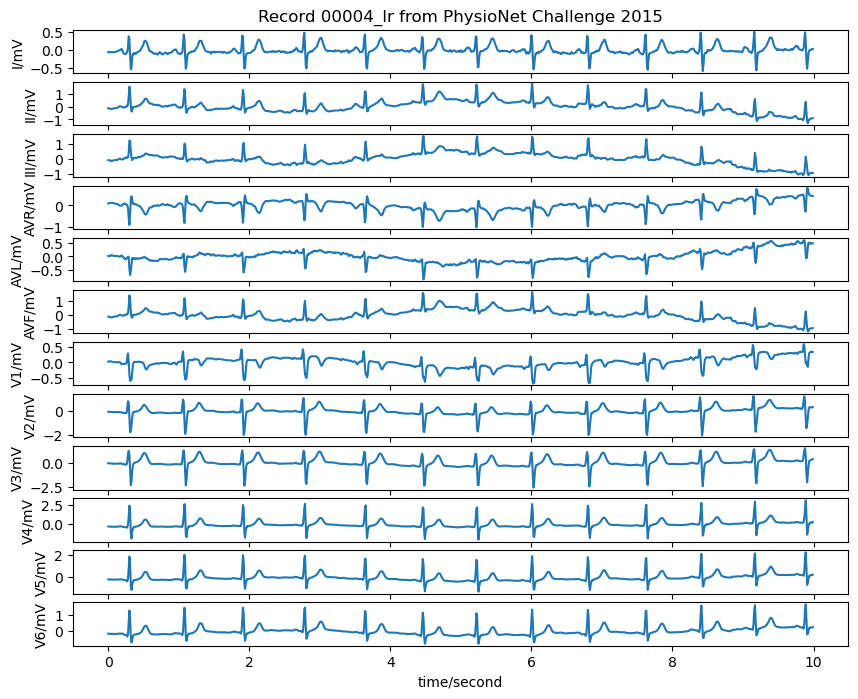

In [89]:
# ECG file path
path = '../data/physionet.org/files/ptb-xl/1.0.3/records100/00000/'
ecg = '00004_lr'
file = path + ecg

# Read record
record = wfdb.rdrecord(file)

# Plot ECG signals
wfdb.plot_wfdb(record=record, title=f'Record {ecg} from PhysioNet Challenge 2015', figsize=(10,8)) 
# display(record.__dict__)

<a id='signal'></a>
Looking at the visual above, we see that each ECG record actually has 12 signals, this is because we are working with 12-lead ECGs. Let's take a closer look at how one ECG lead looks like. We will load Lead II.

Metadata: 
 {'fs': 100, 'sig_len': 1000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['II'], 'comments': []}


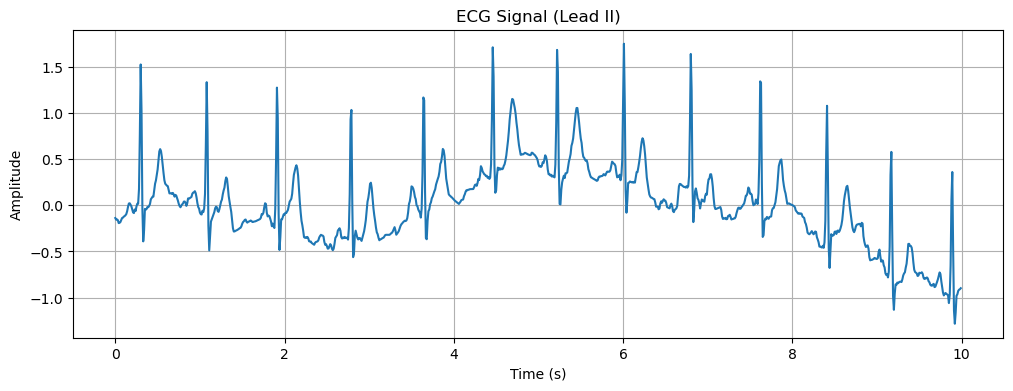

In [90]:
# Read lead II
signals, fields = wfdb.rdsamp(file, channels=[1])  # channels = leads

# Print metadata
print("Metadata: \n", fields)

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency

# Plot the ECG signal
plt.figure(figsize=(12, 4))
plt.plot(time, signals)
plt.title('ECG Signal (Lead {})'.format(sig_name[0]))
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()

We see that in Lead II, the signal has an overall wave to it along with some artifact. 

<a id='example'></a>
### Example signals from each diagnostic superclass
Now we will look at signals from each diagnostic superclass and compare how they look to see if we can detect any difference. We will be using our own function we created in `functions.py` to load a sample of the data. 

In [91]:
# General data file path since we are loading more than one ECG record
path = '../data/physionet.org/files/ptb-xl/1.0.3/'

# We sample from our metadata file which also contains the rest of the file path for each ECG signal
metadata = pd.read_csv('../data/cleaned_metadata.csv')

# We will grab 100 samples from our data set using our function 
X_sample, y_sample = f.load_sample_signal(1000, path, metadata, random_state=42)

Check the shape to make sure its correct. 

**Note**: By default, our function loads the low sampling rate ECG signals (100 Hz). If we wish to load the high sampling rate signals, we can specify it using the `freq` parameter. 

In [92]:
X_sample.shape

(1000, 1000, 12)

Notice we have 100 ECG records, each record is 1000 samples long, plus we have 12 leads. Let's look at the unique diagnostic classes and the number of samples we have for each.

In [93]:
y_sample

6292         ['STTC']
6107           ['CD']
9487         ['NORM']
9724     ['CD', 'MI']
7781           ['CD']
             ...     
11668          ['CD']
8653         ['NORM']
9057         ['NORM']
1346         ['STTC']
5464         ['NORM']
Name: diagnostic_superclass, Length: 1000, dtype: object

In [94]:
# Unique diagnostic classes in our sample data
diagnosis = y_sample.unique()
diagnosis

array(["['STTC']", "['CD']", "['NORM']", "['CD', 'MI']", "['MI']",
       "['NORM', 'CD']", "['HYP']", "['STTC', 'HYP']", "['STTC', 'CD']",
       "['STTC', 'MI']"], dtype=object)

In [95]:
# Number of samples for each diagnostic class
for i in diagnosis:
    print(f"There are {len(X_sample[y_sample == i])} - {i} signals")

There are 157 - ['STTC'] signals
There are 179 - ['CD'] signals
There are 450 - ['NORM'] signals
There are 43 - ['CD', 'MI'] signals
There are 82 - ['MI'] signals
There are 7 - ['NORM', 'CD'] signals
There are 14 - ['HYP'] signals
There are 27 - ['STTC', 'HYP'] signals
There are 16 - ['STTC', 'CD'] signals
There are 25 - ['STTC', 'MI'] signals


For simplicity, we will only look at one lead. According to [Meek & Morris (2002)](#2), **Lead II** is mostly used for recording rhythm strip, so we will use that. 

In [96]:
X_sample = X_sample[:, :, 1] # only take Lead II
X_sample.shape

(1000, 1000)

Let's plot all the signals over each other by diagnostic class to let us see visually if there are any differences we can detect. 

In [97]:
# Signal length and frequency 
sig_len = X_sample.shape[1]
sig_freq = 100

# Time axis
time = np.arange(sig_len) / sig_freq

# Subplot
fig, ax = plt.subplots(figsize=(10, 20), nrows=len(diagnosis), ncols=1, sharex=True)

for i, d in enumerate(diagnosis):
    for j in range(X_sample[y_sample == d].shape[0]):
        ax[i].plot(time, X_sample[y_sample == d][j,:], alpha=0.5)
        ax[i].set_title(f"{d}")
        ax[i].set_ylabel("Amplitude")

ax[4].set_xlabel("Time (s)")
fig.suptitle("Sample ECGs Of The Five Diagnostic Superclass")
fig.tight_layout()

From these plots we can confidently conclude that it is really hard to distinguish the signals between the five different types of diagnostic superclass. Let's try to simplify it by splitting our data to **Normal** and **Abnormal** and perform a test to see if there is even a statistical significance in distinguishing between these two classes.

<a id='statistics'></a>
### Statistical Analysis

We will compare our difference signal classes in the form of **Normal** and **Abnormal** and see if they are easily distinguished from each other. This will give us a sense of why we want to use Fourier Transforms. We will perform ANOVA as our analysis. As a reminder, ANOVA or ANalysis Of VAriance looks at whether there is actually a difference between the variance of two or more groups. In our case, we are taking the mean of each ECG signal and then looking at the variance of the means for each diagnostic class.

**Hypothesis**: 

$$ \begin{align}
H_0: & \text{ The signal between Normal and Abnormal are equal}
\\
H_1: & \text{ The signal between Normal and Abnormal are } not \text{ equal}
\end{align}$$

We are trying to look at if there is any statistical significance in the difference between normal and abnormal signals. Resplitting our data by normal vs abnormal and taking the mean across each time sample: 

In [98]:
y_sample

6292         ['STTC']
6107           ['CD']
9487         ['NORM']
9724     ['CD', 'MI']
7781           ['CD']
             ...     
11668          ['CD']
8653         ['NORM']
9057         ['NORM']
1346         ['STTC']
5464         ['NORM']
Name: diagnostic_superclass, Length: 1000, dtype: object

In [99]:
y_sample.apply(lambda x: ('NORM' not in x) or ('NORM' and 'CD' in x))

6292      True
6107      True
9487     False
9724      True
7781      True
         ...  
11668     True
8653     False
9057     False
1346      True
5464     False
Name: diagnostic_superclass, Length: 1000, dtype: bool

In [100]:
# Normal/abnormal split and taking the mean 
normal = X_sample[y_sample.apply(lambda x: ('NORM' in x) & ('CD' not in x))].mean(axis=0)
abnormal = X_sample[y_sample.apply(lambda x: ('NORM' not in x) or ('NORM' and 'CD' in x))].mean(axis=0)

normal.shape, abnormal.shape

((1000,), (1000,))

We are taking the mean to reduce the dimensions for ANOVA. Now let's perform the statistical test. 

In [101]:
from scipy import stats

# ANOVA between Normal and Abnormal ECGs
stats.ttest_ind(normal, abnormal)

Ttest_indResult(statistic=5.2059352818045515, pvalue=2.128369590289279e-07)

We can do the same hypothesis test directly on our multiclass diagnostic classes as well. 

**Hypothesis**: 

$$ \begin{align}
H_0: & \text{ The signal between NORM, HYP, CD, MI, STTC, CD & MI, NORM & CD, STT & HYP, STTC & CD, STTC & MI  are equal}
\\
H_1: & \text{ The signal between NORM, HYP, CD, MI, STTC, CD & MI, NORM & CD, STT & HYP, STTC & CD, STTC & MI are } not \text{ equal}
\end{align}$$

In [102]:
# ANOVA between the five diagnostic classes
stats.f_oneway(X_sample[y_sample == 'NORM'].mean(axis=0), 
               X_sample[y_sample == 'HYP'].mean(axis=0),
               X_sample[y_sample == 'CD'].mean(axis=0),
               X_sample[y_sample == 'MI'].mean(axis=0),
               X_sample[y_sample == 'STTC'].mean(axis=0))

/var/folders/hw/t1cnzkgd34db0qbsch9qjy7c0000gn/T/ipykernel_66271/1805771560.py:2: RuntimeWarning: Mean of empty slice.
  stats.f_oneway(X_sample[y_sample == 'NORM'].mean(axis=0),
/Users/ChanFamily/opt/anaconda3/envs/ecgcap/lib/python3.8/site-packages/numpy/core/_methods.py:162: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/var/folders/hw/t1cnzkgd34db0qbsch9qjy7c0000gn/T/ipykernel_66271/1805771560.py:3: RuntimeWarning: Mean of empty slice.
  X_sample[y_sample == 'HYP'].mean(axis=0),
/var/folders/hw/t1cnzkgd34db0qbsch9qjy7c0000gn/T/ipykernel_66271/1805771560.py:4: RuntimeWarning: Mean of empty slice.
  X_sample[y_sample == 'CD'].mean(axis=0),
/var/folders/hw/t1cnzkgd34db0qbsch9qjy7c0000gn/T/ipykernel_66271/1805771560.py:5: RuntimeWarning: Mean of empty slice.
  X_sample[y_sample == 'MI'].mean(axis=0),
/var/folders/hw/t1cnzkgd34db0qbsch9qjy7c0000gn/T/ipykernel_66271/1805771560.py:6: RuntimeWarning: Mean of empty slice.
  X_sample[y_sample == 'STTC'].mea

F_onewayResult(statistic=nan, pvalue=nan)

Looking at both results, we see that whether or not we group our classes to normal vs abnormal or keep them as is, the p-value is still above a 0.05 threshold, meaning we cannot reject the Null hypothesis, that the signals are equal. This means that when we model, our models will have a hard time distinguishing between each signal class. As a result, we need to use a method to help our models. This is where Fourier Transforms come in. 

<a id='fourier'></a>
### Fourier Analysis 

In order to better understand our signals, we need a method of cleaning them first. **Fourier Transforms** is a method of transforming time series signals to frequency based. Instead of having time on the x-axis, we can transform it into frequency instead. The benefit of this comes in when we are trying to remove high and low frequency noise in our ECG signals. ECGs signals are often obscured by noise during the recording process, resulting in poor records. Fourier transforms can help fix this problem by removing those noise.

To break it down, we can first talk about signals. Below we great some simple graphs to explain Fourier Transforms.

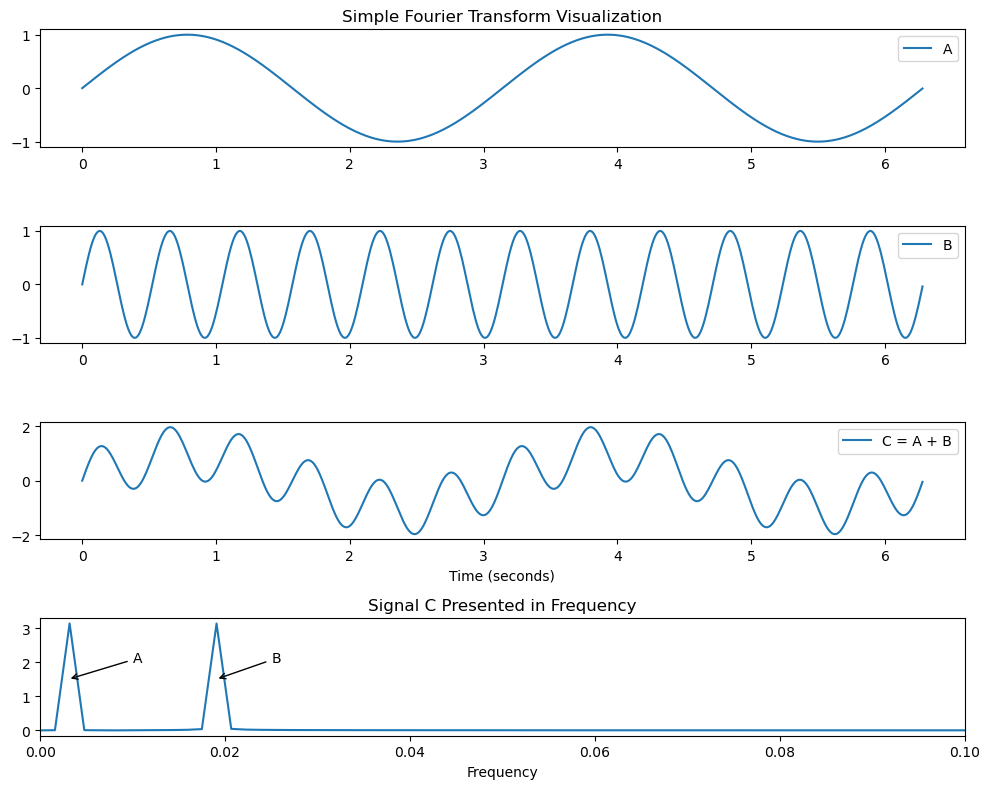

In [103]:
# Creating subplots
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,8))

# One period cycle
t = np.arange(0, 2*np.pi, 0.01)

# Convert to to frequency
f = np.fft.fftshift(np.fft.fftfreq(len(t)))

# Fourier transform signal 
sig = np.fft.fftshift(np.fft.fft(np.sin(2*t)+np.sin(12*t)) * 0.01)

# Plot signals individually and together
ax[0].plot(t, np.sin(2*t), label='A')
ax[1].plot(t, np.sin(12*t), label='B')
ax[2].plot(t, np.sin(2*t)+np.sin(12*t), label='C = A + B')
ax[3].plot(f, np.abs(sig))

ax[0].set_title("Simple Fourier Transform Visualization")
ax[0].legend()
ax[1].legend()
ax[2].set_xlabel("Time (seconds)")
ax[2].legend()
ax[3].set_title("Signal C Presented in Frequency")
ax[3].set_xlabel("Frequency")
ax[3].set_xlim(0, 0.1)
ax[3].annotate("A", (0.003, 1.5), xytext=(0.01, 2), arrowprops=dict(arrowstyle="->", facecolor='black'))
ax[3].annotate("B", (0.019, 1.5), xytext=(0.025, 2), arrowprops=dict(arrowstyle="->", facecolor='black'))

fig.tight_layout()


**Explanation**:
1. Looking at the plots above, we have two sine waves or signals, A and B. These two signals have different frequencies. 
2. If we add A and B together, we get C. 
3. This concept can be generalized: 
    - Any complicated (periodic) signals that are like C can be broken down to simpler ones of different frequencies, such as what we have here with A and B. 
4. If we look at C in terms of frequency, we see that there are two spikes. These represents the frequencies that make up signal C. 
    - Guess what, this is just the frequency of signal A and signal B!! 
    
This is the fundamental concept we are utilizing. Our ECG signals are like signal C, complicated and full of noise. If we break down our signal and look at its constituent frequencies, we can specifically remove those frequencies that are associated with noise. 

To apply this concept to our ECG signals, we use Fast Fourier Transforms (FFT) which NumPy has readily available.

**Example 1**
- Testing out FFT on ECG

Let's go back to the signal we first imported [here](#signal). First we get the sampling interval, $T$. We know that $T = \frac{1}{f_s}$ where $f_s$ is the sampling frequency. 

In [104]:
# First we get the sampling interval 
dt = 1/sampling_frequency

Note that the ECG signal is given in a 2D array. We need to convert it to 1D before applying FFT.
> The following method was taken from [here](https://dsp.stackexchange.com/questions/53272/fourier-transform-of-ecg-signal-in-python).

In [105]:
# Flatten the signal from 2D to 1D 
signals = signals.flatten()

Finally, we can calculate the FFT and plot it 

In [106]:
# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)

# Convert time sample size to frequency
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

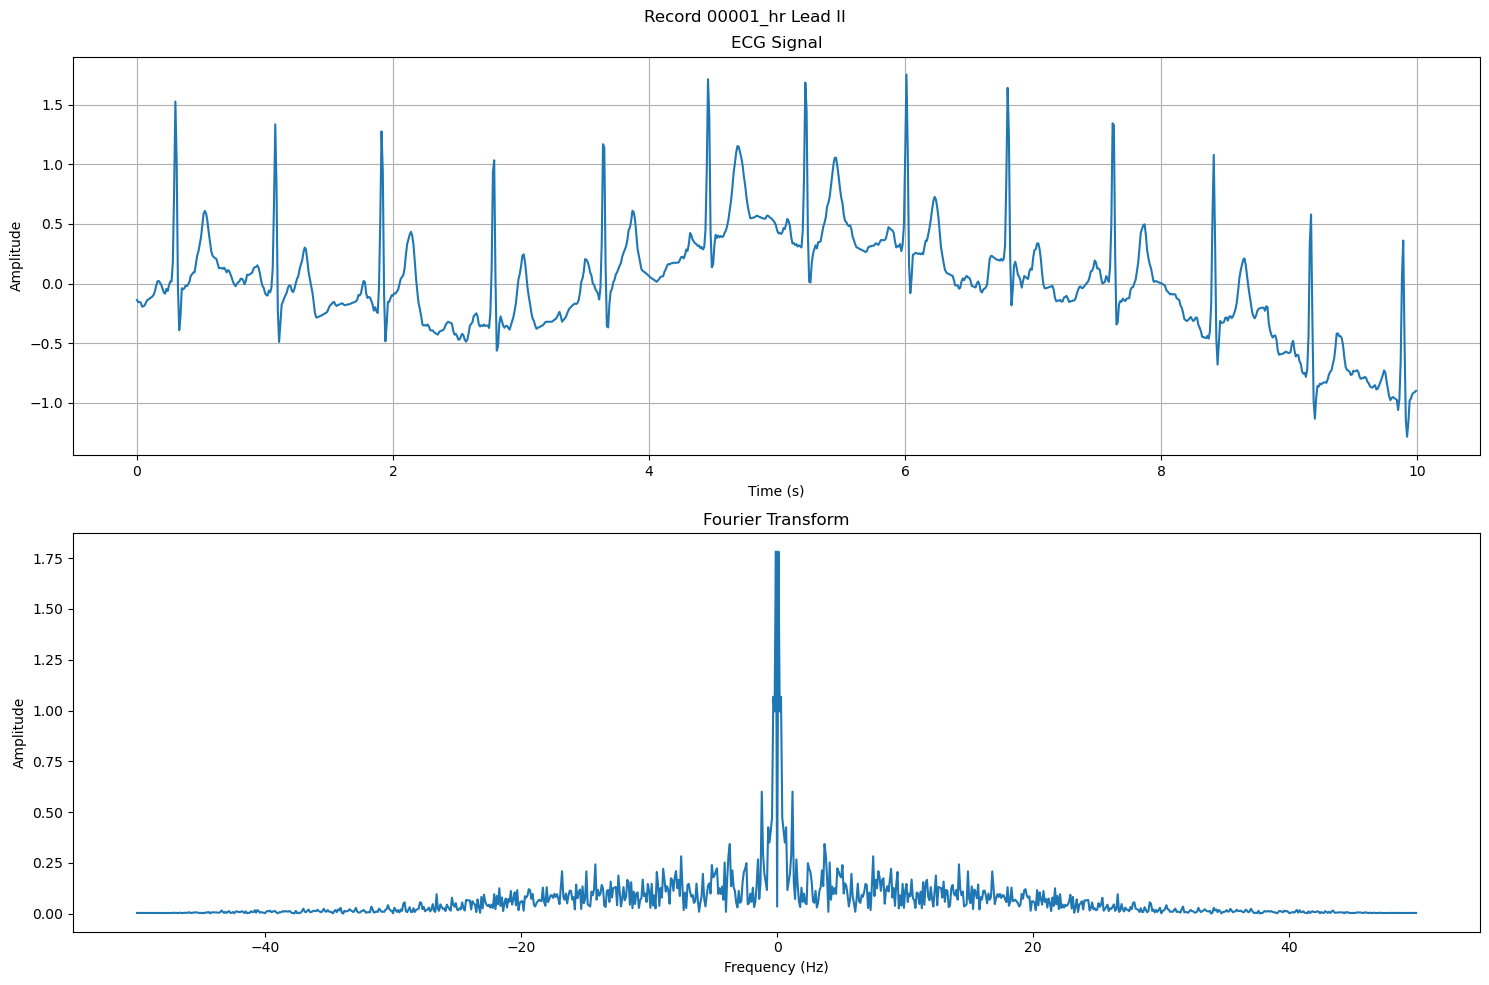

In [107]:
# Plot original time series and fourier transformed version
fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('ECG Signal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Fourier Transform')
#ax[1].set_xlim(-200, 200)
fig.tight_layout()
 
fig.savefig('ecg_fft_example.jpeg')

We see that in Fourier space, we have an arrow like structure, where most of the ECG signal contains low frequency waves. Naturally, the frequencies range from negative to positive, they are just telling the same thing. 

**Example 2**
- Let's try to do the same thing for lead V4 which has less artifact or noise in it

In [108]:
# Read signal and metadata
signals, fields = wfdb.rdsamp(file, channels=[9])  # Change channels=[0] based on your needs

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Print metadata
print("Metadata: \n", fields)

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency

Metadata: 
 {'fs': 100, 'sig_len': 1000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['V4'], 'comments': []}


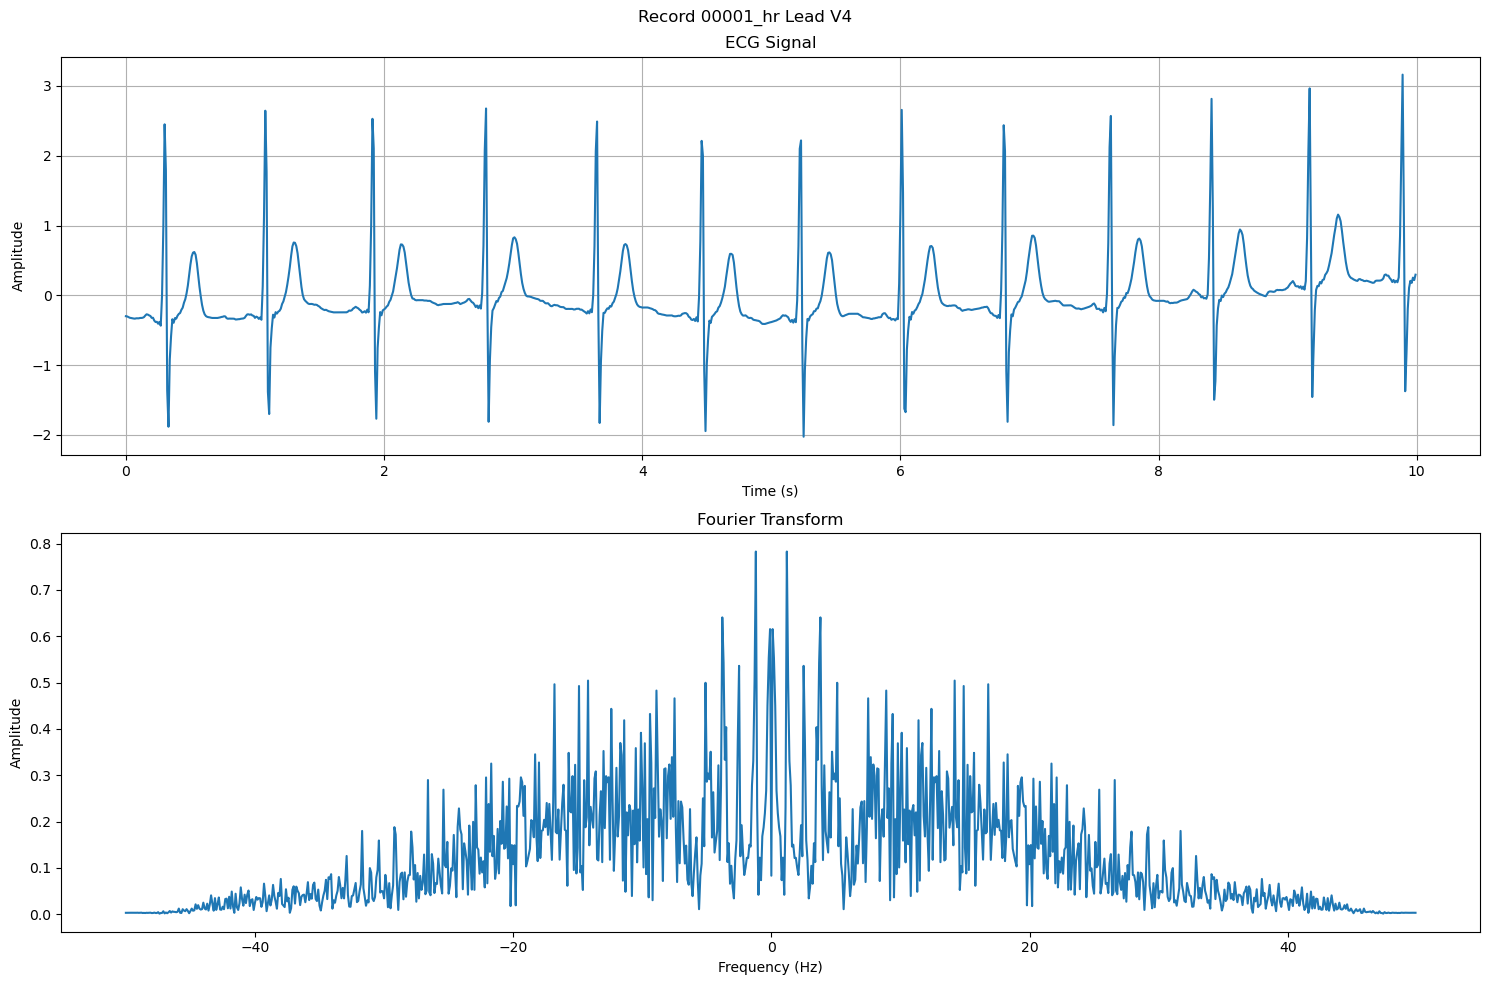

In [109]:
# First we get the sampling interval 
dt = 1/sampling_frequency

# Flatten the signal from 2D to 1D 
signals = signals.flatten()

# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

# Subplot
fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('ECG Signal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Fourier Transform')
#ax[1].set_xlim(0, 100)
fig.tight_layout()
 
fig.savefig('')

In this example, we see that with an ECG that has less fluctuation, in Fourier space it spans wider in range.

### Baseline Removal
We will implement baseline removal through the FFT-IFFT method as outlined by [Dave & Pandya (2018)](#1).

Say we want to remove a baseline frequency from $f=0$ to $f=1.5$, we need to find the corresponding indices in our dataset to be set to zero. 

In [110]:
# Frequency removal range
freq_start = 0
freq_stop = 1.5
freq_step = 0.1 

baseline_freq = np.arange(freq_start, freq_stop, freq_step)
baseline_freq

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4])

Again we will use the same signal as we did in example 1, **except** this time we will use the high sampling rate version, ($f_s = 500$ Hz).

Metadata: 
 {'fs': 500, 'sig_len': 5000, 'n_sig': 1, 'base_date': None, 'base_time': None, 'units': ['mV'], 'sig_name': ['II'], 'comments': []}


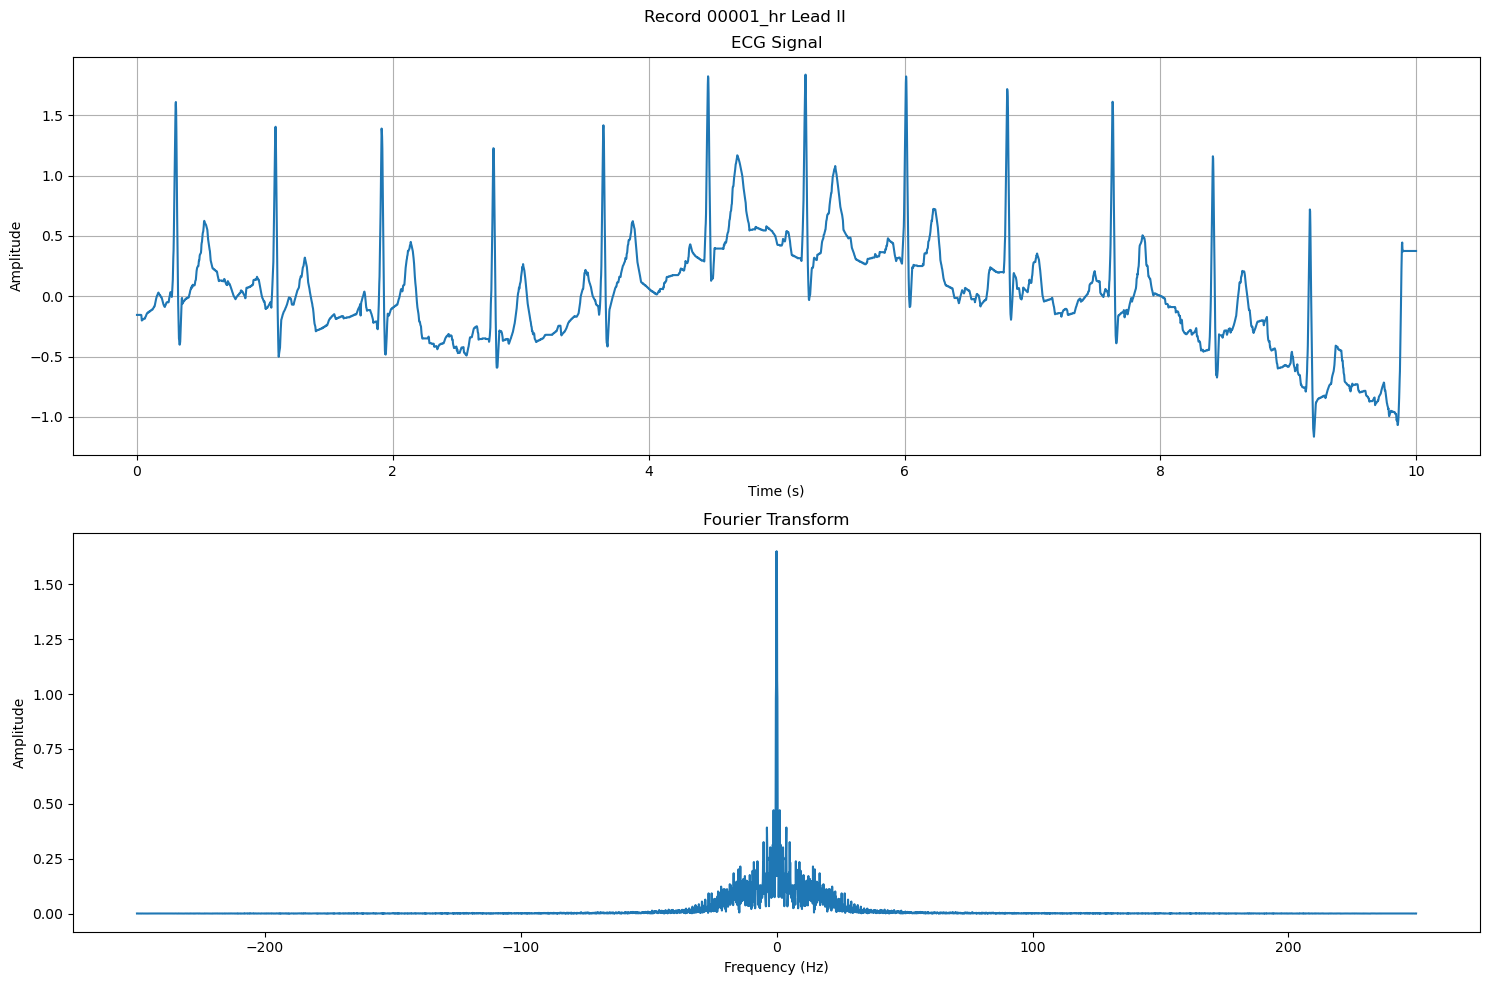

In [111]:
# File path for high frequency sampling
path = '../data/physionet.org/files/ptb-xl/1.0.3/records500/00000/'
file = path+'00004_hr'

# Read signal and metadata
signals, fields = wfdb.rdsamp(file, channels=[1])  # Channels = Leads

sampling_frequency = fields['fs']  # Sampling frequency
sig_len = fields['sig_len'] # Signal length 
sig_name = fields['sig_name'] # Lead

# Print metadata
print("Metadata: \n", fields)

# Convert to time series
time = np.arange(0, sig_len) / sampling_frequency

# First we get the sampling interval 
dt = 1/sampling_frequency

# Flatten the signal from 2D to 1D 
signals = signals.flatten()

# FFT returns a result not centered at zero, therefore we need to fftshift it to zero
signal_fft = np.fft.fftshift(np.fft.fft(signals) * dt)
freq = np.fft.fftshift(np.fft.fftfreq(sig_len, dt))

fig, ax = plt.subplots(2, 1, figsize=(15,10))

fig.suptitle("Record 00001_hr Lead %s" % (sig_name[0]))
ax[0].plot(time, signals)
ax[0].set_title('ECG Signal')
ax[0].set_xlabel('Time (s)')
ax[0].set_ylabel('Amplitude')
ax[0].grid(True)
ax[1].plot(freq, np.abs(signal_fft))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title('Fourier Transform')
#ax[1].set_xlim(0, 100)
fig.tight_layout()

Now we will remove the frequencies we specified above. To do this, we will first take a copy of our data first and perform it on the copy, so we that we can see the difference before and after. Knowing which frequencies we want to remove, we need to translate this to which indices to remove in our 5000 sample point data. 

In [112]:
# Copy the signal so we won't change the original data 
test_signal_fft = signal_fft.copy()

N = len(test_signal_fft)
Fs = sampling_frequency

for i, f in enumerate(baseline_freq):
    
    # Knowing which frequencies to cut off, we find the index that they belong to in our data set
    start = 0
    stop = int(round(f*N/Fs, 0) - 1)
    
    # Set those data points to zero 
    test_signal_fft[start+2500:stop+2500] = 0
    test_signal_fft[start+2500-(i+1):stop+2500-(i+1)] = 0

Plotting the original signal in Fourier space and after the specified frequencies have been removed. 

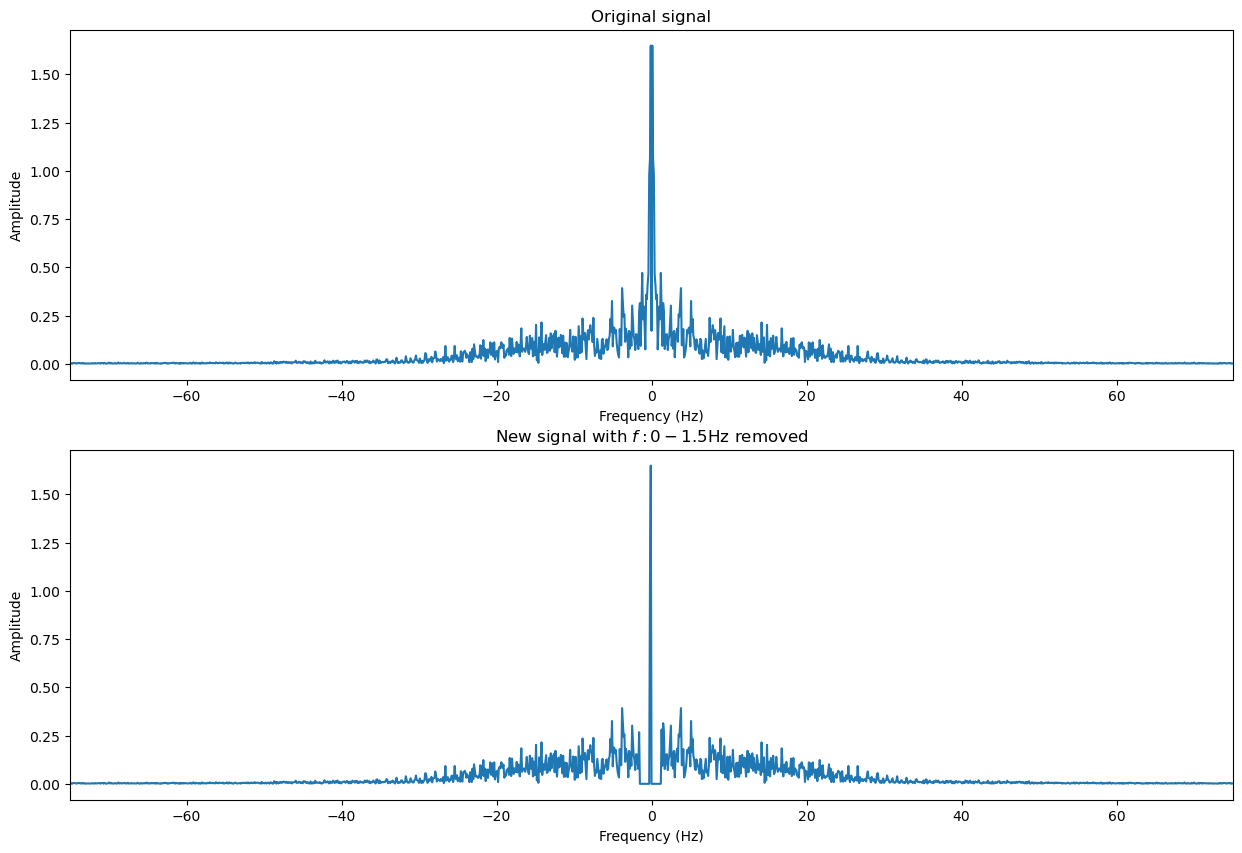

In [113]:
# Before and after frequency removal 
fig, ax = plt.subplots(2, 1, figsize=(15,10))

ax[0].plot(freq, np.abs(signal_fft))
ax[0].set_title('ECG Signal')
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')
ax[0].set_title(r"Original signal")
ax[0].set_xlim(-75, 75)
ax[1].plot(freq, np.abs(test_signal_fft))
ax[1].set_title('ECG Signal')
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude')
ax[1].set_title(r"New signal with $f: 0-1.5 \rm Hz$ removed")
ax[1].set_xlim(-75, 75);

Now we will plot the signals with and without frequency removal. 

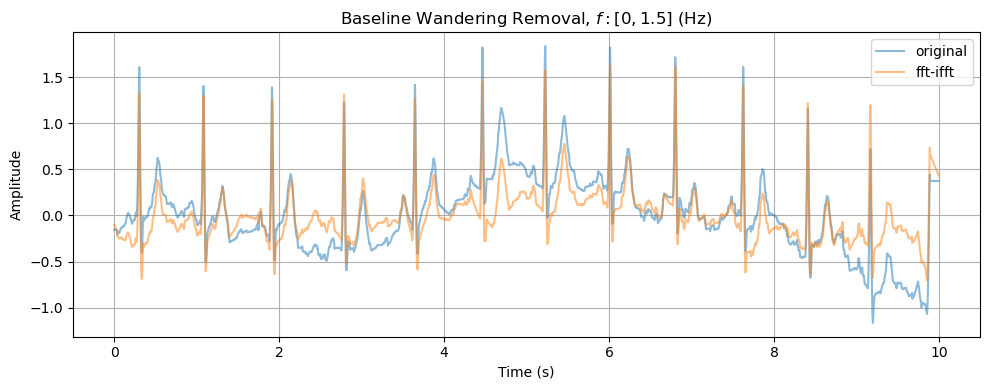

In [114]:
# Inverse FFT our signal back to the time domain
new_signal = np.fft.ifft(np.fft.ifftshift(test_signal_fft)) / dt

# Plot
plt.figure(figsize=(10,4))
plt.plot(time, signals, label="original", alpha=0.5)
plt.plot(time, np.real(new_signal), label="fft-ifft", alpha=0.5)
plt.title(f"Baseline Wandering Removal, $f: [{freq_start}, {freq_stop}]$ (Hz)")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("baseline_fft.jpg")

plt.show()

In [115]:
len(test_signal_fft)

5000

From the plot above, we can see that our initial frequency removal of $f=0$ to $f=1.5$ does help us reduce our signal down to have a less wavy structure. 

### High Frequency Removal (Power Line Interference?)

Next we will try to remove the high frequency noise in our data. High frequency noise in ECG signals can due to things like Power Line Interference or Muscle Noise (aka eletromyographic interference or EMG). 

First we will try to remove the high frequency noise we see **visually**, that is frequency greater than 40 Hz. We can reuse our code above that we used for baseline wandering and only change the frequency components we are removing. 

In [116]:
# Frequency removal range
freq_start = 49
freq_stop = 51
freq_step = 0.1 

baseline_freq = np.arange(freq_start, freq_stop, freq_step)
baseline_freq

# for i, f in enumerate(baseline_freq):
    
#     # Knowing which frequencies to cut off, we find the index that they belong to in our data set
#     start = 0
#     stop = int(round(f*N/Fs, 0) - 1)
    
#     # Set those data points to zero 
#     test_signal_fft[start+2500:stop+2500] = 0
#     test_signal_fft[start+2500-(i+1):stop+2500-(i+1)] = 0

array([49. , 49.1, 49.2, 49.3, 49.4, 49.5, 49.6, 49.7, 49.8, 49.9, 50. ,
       50.1, 50.2, 50.3, 50.4, 50.5, 50.6, 50.7, 50.8, 50.9])

## References

<a id='1'></a>
Dave, T., & Pandya, U. (2018). Simultaneous monitoring of motion ECG of two subjects using Bluetooth Piconet and baseline drift. Biomedical engineering letters, 8(4), 365–371. https://doi.org/10.1007/s13534-018-0081-4

<a id='2'></a>
Meek, S., & Morris, F. (2002). ABC of clinical electrocardiography.Introduction. I-Leads, rate, rhythm, and cardiac axis. BMJ (Clinical research ed.), 324(7334), 415–418. https://doi.org/10.1136/bmj.324.7334.415